# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [17]:
import pandas as pd
import random

import numpy as np
from numpy.random import (
    default_rng,
    uniform
)
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
from sklearn.model_selection import (
    train_test_split,
    ParameterSampler,
    RandomizedSearchCV
)
from sklearn.utils.fixes import loguniform
import matplotlib.pyplot as plt
import seaborn as sns

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [3]:
dataset = pd.read_csv("./data/loan_data.csv", comment="#")

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [4]:
X_test

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
724,4200,50216.0,58541.0,19.0,0.0,0.0,209.871302,0.0,19.0,20.208033
652,19300,50554.0,76140.0,9.0,2.0,0.0,78.276625,3.0,27.0,36.026904
825,13000,78766.0,106450.0,6.0,0.0,0.0,107.951312,0.0,26.0,24.870994
1636,11800,67678.0,108092.0,13.0,0.0,7.0,126.658232,0.0,36.0,37.162690
18,87500,55938.0,86794.0,15.0,0.0,0.0,223.881040,0.0,16.0,36.753653
...,...,...,...,...,...,...,...,...,...,...
485,79100,23553.0,103807.0,25.0,0.0,1.0,142.193458,0.0,13.0,31.469937
1702,16300,79087.0,102921.0,23.0,0.0,0.0,256.253084,0.0,45.0,36.987086
511,26900,72848.0,101736.0,10.0,0.0,0.0,131.409634,0.0,21.0,36.369027
1406,13000,80587.0,110064.0,6.0,0.0,0.0,85.009197,1.0,13.0,33.990040


In [5]:
y_train

1240    0
1183    0
692     0
871     0
1353    0
       ..
835     0
1216    0
1653    1
559     0
684     0
Name: TARGET, Length: 1483, dtype: int64

In [6]:
y_train.value_counts()

0    1232
1     251
Name: TARGET, dtype: int64

In [7]:
y_test

724     0
652     0
825     0
1636    1
18      0
       ..
485     0
1702    1
511     0
1406    0
1670    1
Name: TARGET, Length: 371, dtype: int64

In [8]:
y_test.value_counts()

0    313
1     58
Name: TARGET, dtype: int64


Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

---

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

**No hace falta escribir código para responder estas preguntas.**

#### __RESPUESTAS__

__¿De qué se trata el conjunto de datos?__  
Es un conjunto de datos parcial que contiene datos de cada formulario de solicitud que rellenan los solicitantes de prestamos hipotecarios realizado por la empresa Dream Housing Finance, con el objetivo de determinar, mediante la automatizacion de un proceso, la elegibilidad de cada clientes solicitante del prestamo.

__¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?__  
La variable objetivo a predecir es la elegibilidad del cliente para un prestamos hipotecario. Esto implica el uso de informacion recopilada en la encuesta para determinar la idoneidad y confiabilidad de los solicitantes de los prestamos hipotecarios.

__¿Qué información (atributos) hay disponible para hacer la predicción?__  
Para realizar la prediccion disponemos de la informacion aportada por los clientes en el formulario de solicitud de prestamo. Esta informacion esta de forma parcial, contenida en un data set de Kaggle. Contiene las siguientes columnas:
'Loan_ID', 'Gender', 'Married', 'Dependents', 'Education','Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'.

__¿Qué atributos imagina ud. que son los más determinantes para la predicción?__  
Para el analisis de la elegibilidad del cliente para un prestamo hipotecario los atributos mas determinantes son:
'Credit_History','LoanAmount','Self_Employed','ApplicantIncome'.

---

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión (por defecto?) de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

In [9]:
# X_train, X_test, y_train, y_test

## Curación de datos

In [14]:
columns_list = dataset.columns

In [15]:
def histplot_graficos(data_frame, columns_list):
    n=0
    fig, axes = plt.subplots(nrows=len(columns_list), figsize=(20, 60))
    for i in columns_list:
        print(i)
        sns.histplot(data_frame[i], ax=axes[n], color='gray')
        #sns.histplot(data = data_frame,  x = i, ax=axes[n],hue='Class') -->con hue
        n+=1

In [13]:
dataset

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106
...,...,...,...,...,...,...,...,...,...,...,...
1849,1,53400,228236.0,305514.0,6.0,0.0,0.0,11.148069,0.0,2.0,34.558417
1850,1,53600,235895.0,299772.0,5.0,0.0,0.0,112.748282,7.0,22.0,44.945929
1851,1,53600,208197.0,297280.0,4.0,1.0,1.0,160.485251,2.0,29.0,41.646731
1852,1,65500,205156.0,290239.0,2.0,0.0,0.0,98.808206,1.0,21.0,144.189001


In [19]:
dataset.loc[dataset.TARGET == 0]

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106
...,...,...,...,...,...,...,...,...,...,...,...
1540,0,16100,99844.0,114647.0,11.0,0.0,0.0,169.983556,0.0,27.0,33.523279
1541,0,38600,145590.0,209950.0,4.0,0.0,0.0,149.881129,0.0,31.0,35.582789
1542,0,18200,62141.0,90434.0,0.0,0.0,0.0,69.410777,0.0,22.0,35.357287
1543,0,16400,50941.0,78801.0,4.0,0.0,0.0,266.040799,2.0,32.0,32.904357


<AxesSubplot:>

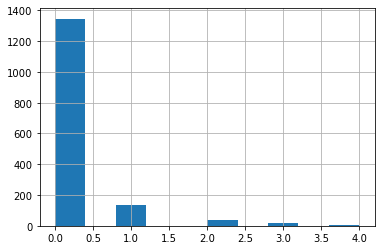

In [27]:
dataset.loc[dataset.TARGET == 0]["DELINQ"].hist()

<AxesSubplot:>

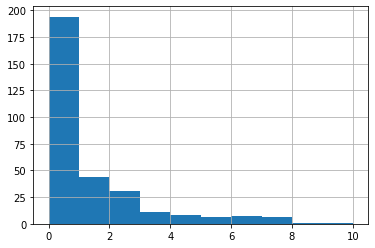

In [28]:
dataset.loc[dataset.TARGET == 1]["DELINQ"].hist()

TARGET
LOAN
MORTDUE
VALUE
YOJ
DEROG
DELINQ
CLAGE
NINQ
CLNO
DEBTINC


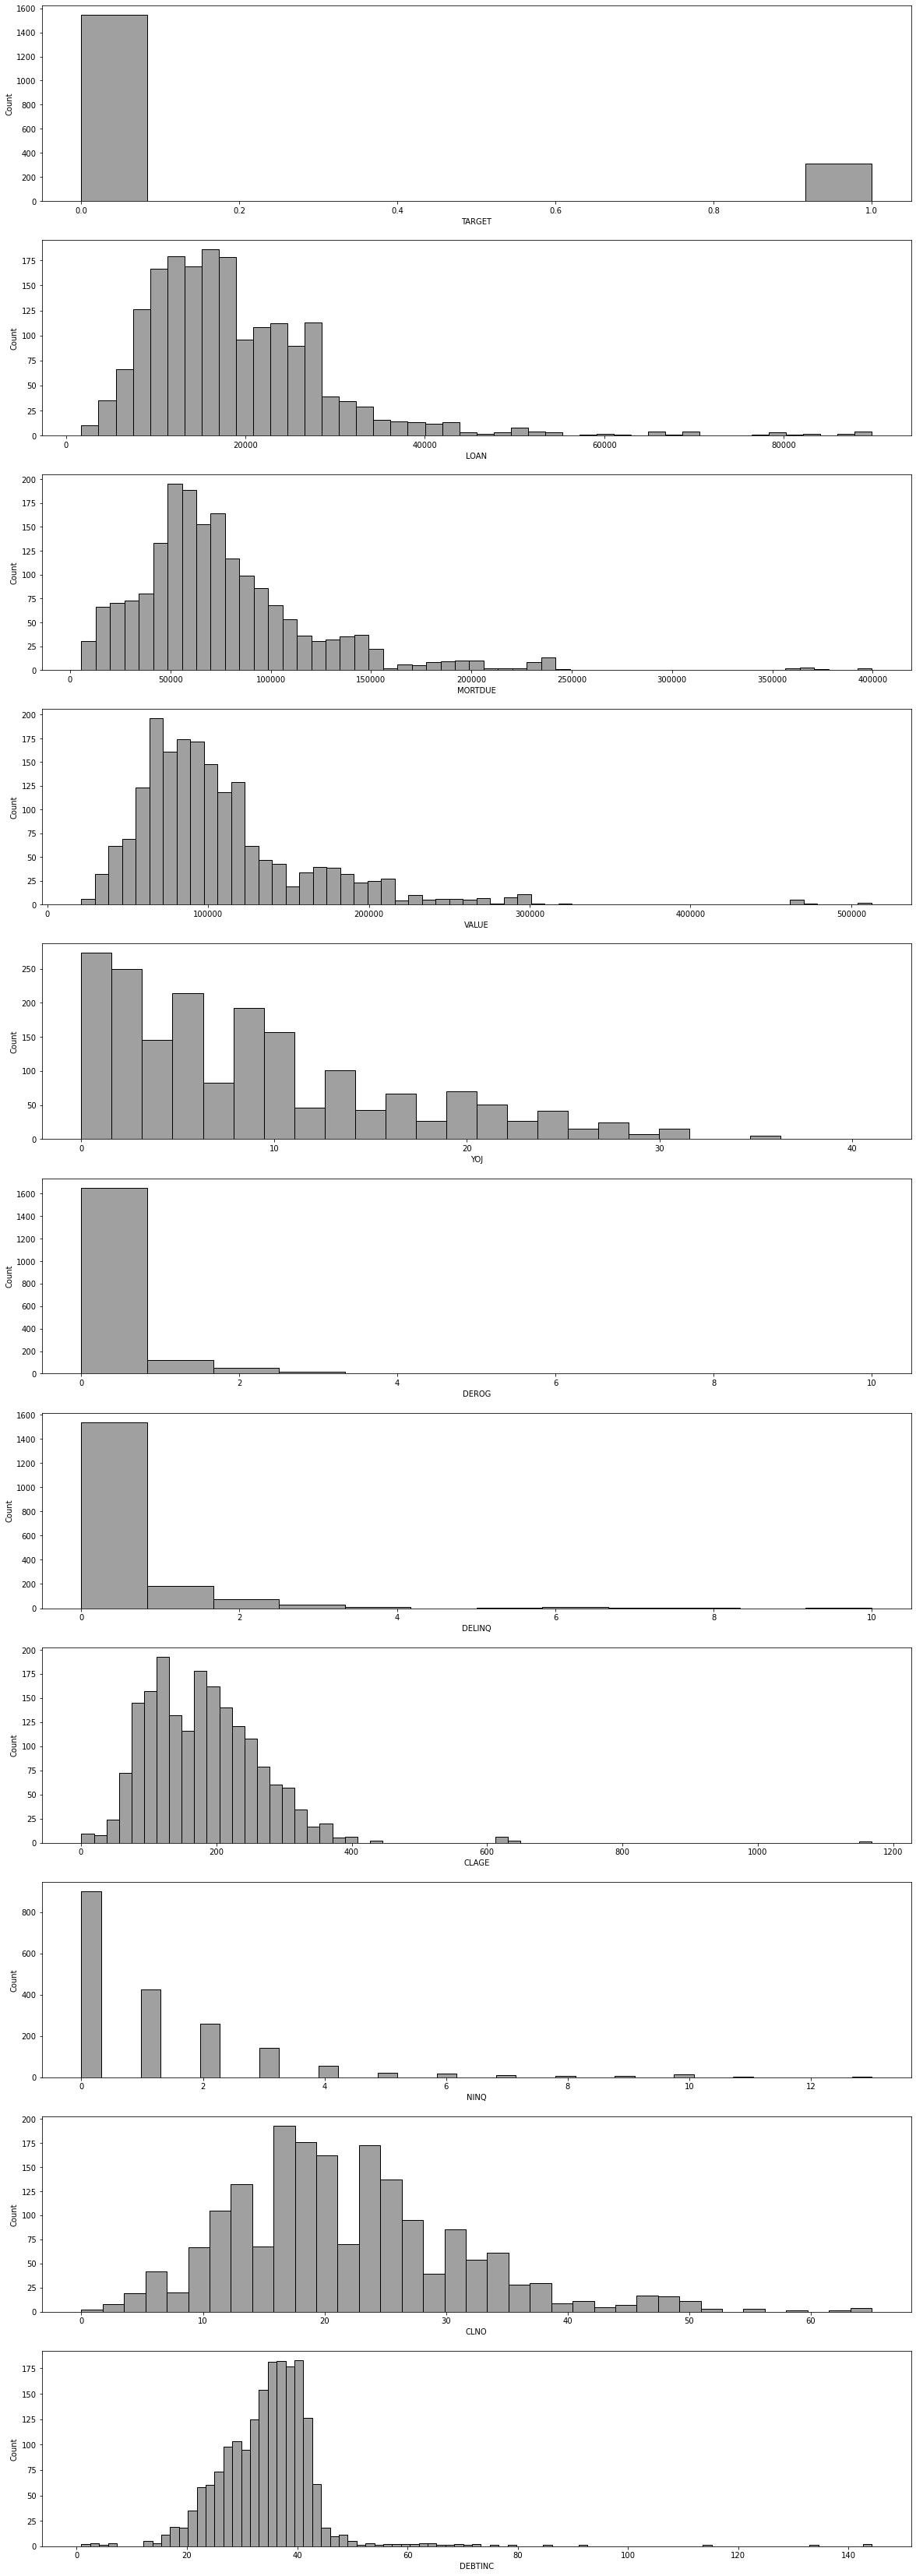

In [18]:
histplot_graficos(dataset, columns_list)

#### Valor de Semilla aleatoria

In [10]:
rng = default_rng()
rints = rng.integers(low=0, high=100, size=1)
print(f'⦁ rints = {rints}')
rint = rints[0]
print(f'⦁ rint = {rint}') ### Ejemplo tomado: 46 | 24

⦁ rints = [37]
⦁ rint = 37


In [11]:
rint = 5

### Linear SVM

In [12]:
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=10000, random_state=rint)
clf.fit(X_train, y_train)           # Entrenamiento
y_train_pred = clf.predict(X_train)  # Predicción → Evaluación sobre set de entrenamiento
y_test_pred = clf.predict(X_test)   # Predicción → Evaluación sobre set de test

#### Evaluación sobre conjunto de entrenamiento

In [18]:
np.set_printoptions(threshold=np.inf)

In [19]:
print(f'⦁ y_train:\n\n{np.array(y_train)}\n')
print('---'*25)
print(f'\n⦁ y_train_pred:\n\n{y_train_pred}\n')

⦁ y_train:

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1
 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 1 1 0 

In [20]:
df = pd.DataFrame(data=y_pred, columns=['y_pred'])

NameError: name 'y_pred' is not defined

In [19]:
df['y_test'] = np.array(y_test)

In [20]:
df = df[['y_test', 'y_pred']]

In [27]:
df.shape

(371, 2)

In [31]:
df.iloc[:20].style.background_gradient(cmap="Blues")

,y_test,y_pred
0,0,0
1,0,0
2,0,0
3,1,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


## Métricas

In [22]:
accuracy_score(y_test, y_pred)

0.8409703504043127

In [23]:
precision_score(y_test, y_pred, zero_division=1)

0.0

In [24]:
recall_score(y_test, y_pred)

0.0

In [25]:
f1_score(y_test, y_pred)

0.0

In [32]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() #, normalize='all')
(tn, fp, fn, tp)

(312, 1, 58, 0)

In [33]:
confusion_matrix(y_test, y_pred)

array([[312,   1],
       [ 58,   0]])

In [16]:
print(f'⦁ y_test:\n\n{np.array(y_test)}\n')
print('---'*25)
print(f'\n⦁ y_pred:\n\n{y_pred}')

⦁ y_test:

[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1
 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 1]

---------------------------------------------------------------------------

⦁ y_pred:

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [18]:
df = pd.DataFrame(data=y_pred, columns=['y_pred'])

In [19]:
df['y_test'] = np.array(y_test)

In [20]:
df = df[['y_test', 'y_pred']]

In [27]:
df.shape

(371, 2)

In [31]:
df.iloc[:20].style.background_gradient(cmap="Blues")

,y_test,y_pred
0,0,0
1,0,0
2,0,0
3,1,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


## Métricas

In [22]:
accuracy_score(y_test, y_pred)

0.8409703504043127

In [23]:
precision_score(y_test, y_pred, zero_division=1)

0.0

In [24]:
recall_score(y_test, y_pred)

0.0

In [25]:
f1_score(y_test, y_pred)

0.0

In [32]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() #, normalize='all')
(tn, fp, fn, tp)

(312, 1, 58, 0)

In [33]:
confusion_matrix(y_test, y_pred)

array([[312,   1],
       [ 58,   0]])

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de:  
- loss  
- tasas de entrenamiento (learning_rate)  
- tasas de regularización

Para ello, usar **grid-search** y **5-fold cross-validation** sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar **accuracy**, **promedio** y **varianza** para todas las configuraciones.

Para la **mejor configuración** encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# Solución basada en notebook de prácticos _"06 Selección de Modelos.ipynb"_

- loss = 'log'  
- learning_rate = 

In [307]:
param_dist = {
    'loss': [
        'hinge',        # SVM
        'log',          # logistic regression
         'perceptron'   
    ],
    'alpha': loguniform(1e-4, 1e2),  # de 0.0001 a 100.0
    'learning_rate': [
        'constant',
        'optimal',
        #'invscaling'
    ],
    'eta0': uniform(
        low=0, high=100, size=30
    ) # The initial learning rate for the ‘constant’, ‘invscaling’ or ‘adaptive’ schedules. Values must be in the range (0.0, inf).
}

Al parámetro alpha lo va a obtener desde muestras de una función de probabilidad tipo loguniform:

Podemos muestrear mano con [ParameterSampler](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterSampler.html):

In [308]:
for params in ParameterSampler(param_dist, 30, random_state=rint):
    print(params)
    model = SGDClassifier(**params, random_state=rint)

{'alpha': 57.557751524131014, 'eta0': 41.927101146956524, 'learning_rate': 'optimal', 'loss': 'log'}
{'alpha': 0.008033954165751046, 'eta0': 45.185320215548295, 'learning_rate': 'optimal', 'loss': 'hinge'}
{'alpha': 5.285491798689512, 'eta0': 85.86353874035476, 'learning_rate': 'optimal', 'loss': 'log'}
{'alpha': 0.00013238773901738391, 'eta0': 54.69816384069597, 'learning_rate': 'optimal', 'loss': 'log'}
{'alpha': 25.554670170487277, 'eta0': 41.927101146956524, 'learning_rate': 'constant', 'loss': 'hinge'}
{'alpha': 1.0735922690147037, 'eta0': 27.69758381965799, 'learning_rate': 'constant', 'loss': 'perceptron'}
{'alpha': 22.94487109562289, 'eta0': 33.029560957255434, 'learning_rate': 'constant', 'loss': 'log'}
{'alpha': 0.23692138799563706, 'eta0': 14.697997475024815, 'learning_rate': 'constant', 'loss': 'hinge'}
{'alpha': 0.011723475683154473, 'eta0': 27.69758381965799, 'learning_rate': 'optimal', 'loss': 'hinge'}
{'alpha': 52.55097933906439, 'eta0': 4.610963998660223, 'learning_rat

### Búsqueda Aleatoria + Validación Cruzada

También podemos dejar que Sklearn se encargue de todo con [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html):


In [309]:
model = SGDClassifier(random_state=rint)
cv = RandomizedSearchCV(model, param_dist, n_iter=30, cv=5, random_state=rint)
cv.fit(X, y);

In [310]:
results = cv.cv_results_

In [311]:
list(results.keys())

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_alpha',
 'param_eta0',
 'param_learning_rate',
 'param_loss',
 'params',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'mean_test_score',
 'std_test_score',
 'rank_test_score']

In [312]:
df = pd.DataFrame(results)
df[[
    'param_loss', 'param_alpha', 
    'param_learning_rate', 'param_eta0',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]]

,param_loss,param_alpha,param_learning_rate,param_eta0,mean_test_score,std_test_score,rank_test_score
0,log,57.557752,optimal,41.927101,0.703415,0.260065,28
1,hinge,0.008034,optimal,45.18532,0.833334,0.000900,1
2,log,5.285492,optimal,85.863539,0.568644,0.319162,30
3,log,0.000132,optimal,54.698164,0.700181,0.266534,29
4,hinge,25.55467,constant,41.927101,0.833334,0.000900,1
5,perceptron,1.073592,constant,27.697584,0.833334,0.000900,1
6,log,22.944871,constant,33.029561,0.833334,0.000900,1
7,hinge,0.236921,constant,14.697997,0.833334,0.000900,1
8,hinge,0.011723,optimal,27.697584,0.833334,0.000900,1
9,log,52.550979,constant,4.610964,0.833334,0.000900,1


In [313]:
cv.best_estimator_

SGDClassifier(alpha=0.008033954165751046, eta0=45.185320215548295,
              random_state=24)

In [314]:
new_params = cv.best_params_
cv.best_params_

{'alpha': 0.008033954165751046,
 'eta0': 45.185320215548295,
 'learning_rate': 'optimal',
 'loss': 'hinge'}

In [315]:
clf = SGDClassifier(
    loss=new_params['loss'],
    alpha=new_params['alpha'],
    learning_rate=new_params['learning_rate'],
    eta0=new_params['eta0'],
    penalty='l2', 
    max_iter=1000, 
    random_state=rint
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [316]:
print(f'⦁ y_test:\n\n{np.array(y_test)}\n')
print('---'*25)
print(f'\n⦁ y_pred:\n\n{y_pred}')

⦁ y_test:

[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1
 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 1]

---------------------------------------------------------------------------

⦁ y_pred:

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 

In [317]:
df = pd.DataFrame(data=y_pred, columns=['y_pred'])

In [318]:
df['y_test'] = np.array(y_test)

In [319]:
df = df[['y_test', 'y_pred']]

In [320]:
df.iloc[:20].style.background_gradient(cmap="Blues")

,y_test,y_pred
0,0,0
1,0,0
2,0,0
3,1,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


## Métricas

In [321]:
accuracy_score(y_test, y_pred)

0.8194070080862533

In [322]:
precision_score(y_test, y_pred, zero_division=1)

0.09090909090909091

In [323]:
recall_score(y_test, y_pred)

0.017241379310344827

In [324]:
f1_score(y_test, y_pred)

0.02898550724637681

In [325]:
confusion_matrix(y_test, y_pred)#, normalize='all')

array([[303,  10],
       [ 57,   1]])

---

# Búsqueda propia de la solución

### Regresión logística

- loss = 'log'  
- learning_rate = 

In [398]:
clf = SGDClassifier(loss='log', penalty='l2', max_iter=1000, random_state=rint)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [399]:
print(f'⦁ y_test:\n\n{np.array(y_test)}\n')
print('---'*25)
print(f'\n⦁ y_pred:\n\n{y_pred}')

⦁ y_test:

[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1
 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 1]

---------------------------------------------------------------------------

⦁ y_pred:

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [400]:
df = pd.DataFrame(data=y_pred, columns=['y_pred'])

df['y_test'] = np.array(y_test)

df = df[['y_test', 'y_pred']]

df.iloc[:20].style.background_gradient(cmap="Blues")

,y_test,y_pred
0,0,0
1,0,0
2,0,0
3,1,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


## Métricas

In [401]:
accuracy_score(y_test, y_pred)

0.8436657681940701

In [402]:
precision_score(y_test, y_pred, zero_division=1)

1.0

In [403]:
recall_score(y_test, y_pred)

0.0

In [404]:
f1_score(y_test, y_pred)

0.0

In [405]:
confusion_matrix(y_test, y_pred)#, normalize='all')

array([[313,   0],
       [ 58,   0]])

---

## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo:  
- __criterion__: probar diferentes criterios de partición  
- __max_depth__: profundidad máxima del árbol    
- __min_samples_leaf__: cantidad mínima de samples por hoja

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

---